# Датасет

In [1]:
import matplotlib.cm as cmap
import numpy as np

from matplotlib import gridspec

In [2]:
N = 500

In [3]:
get_angles = lambda: np.random.randint(0, 360, size=N) / 360. * 2*np.pi
get_dists = lambda s,n: s + n*(np.random.ranf(size=N)*2-1)

In [4]:
rads = get_angles()
xs_1 = get_dists(5, 1) * np.cos(rads)
ys_1 = get_dists(5, 1) * np.sin(rads)
color_1 = np.ones_like(xs_1)

rads = get_angles()
xs_2 = get_dists(4, 1) * np.cos(rads)
ys_2 = get_dists(4, 1) * np.sin(rads)
color_2 = 2*np.ones_like(xs_2)

xs_3 = np.random.ranf(size=N//2)*2-1
ys_3 = np.random.ranf(size=N//2)*6-3
color_3 = 3*np.ones_like(xs_3)

xs_4 = np.random.ranf(size=N//4)+1
ys_4 = np.random.ranf(size=N//4)*6-3

xs_5 = np.random.ranf(size=N//4)-2
ys_5 = np.random.ranf(size=N//4)*6-3

xs_4 = np.hstack((xs_4, xs_5))
ys_4 = np.hstack((ys_4, ys_5))

color_4 = 4*np.ones_like(xs_4)

all_xs = np.hstack((xs_1, xs_2, xs_3, xs_4))
all_ys = np.hstack((ys_1, ys_2, ys_3, ys_4))
all_colors = np.hstack((color_1, color_2, color_3, color_4))

data = pd.DataFrame(data={'x': all_xs, 'y': all_ys, 'color': all_colors })

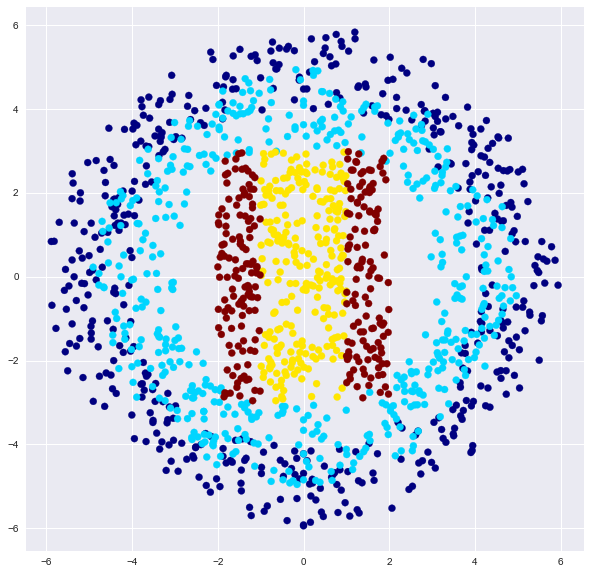

In [5]:
plt.figure(figsize=(10, 10));
plt.scatter(data.x, data.y, c=data.color, cmap=cmap.jet);

# Алгоритмы

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import EnsembleVoteClassifier

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

[ 0.71666667  0.77        0.8         0.78333333  0.73333333]
0.760666666667


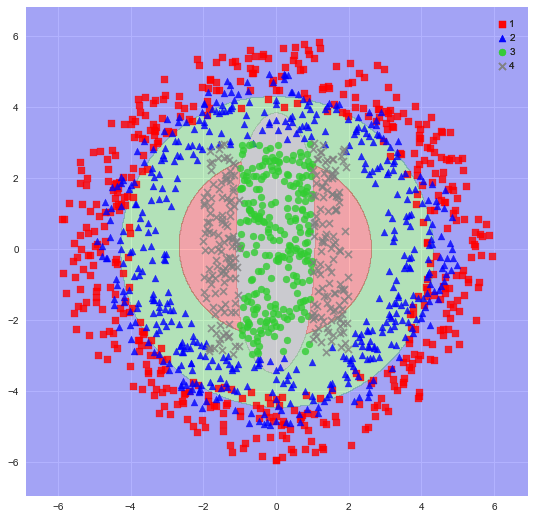

In [11]:
clf = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression())
scores = cross_val_score(clf, data[['x', 'y']], data.color, cv=5)
print(scores)
print(np.mean(scores))

clf.fit(data[['x', 'y']], data.color.values.astype(np.integer));
plt.figure(figsize=(9,9));
plot_decision_regions(data[['x', 'y']].values, data.color.values.astype(np.integer), clf);

[ 0.81333333  0.85666667  0.87        0.86666667  0.80333333]
0.842


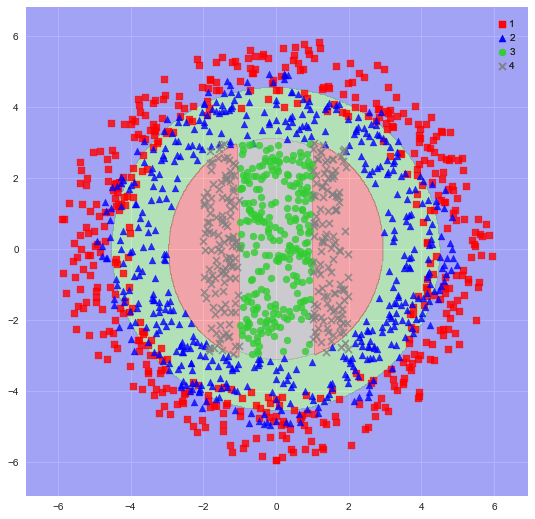

In [12]:
clf2 = SVC(kernel='poly', degree=2)

scores = cross_val_score(clf2, data[['x', 'y']], data.color, cv=5)
print(scores)
print(np.mean(scores))

clf2.fit(data[['x', 'y']], data.color.values.astype(np.integer));
plt.figure(figsize=(9,9));
plot_decision_regions(data[['x', 'y']].values, data.color.values.astype(np.integer), clf2);

[ 0.79666667  0.81666667  0.81333333  0.80666667  0.79666667]
0.806


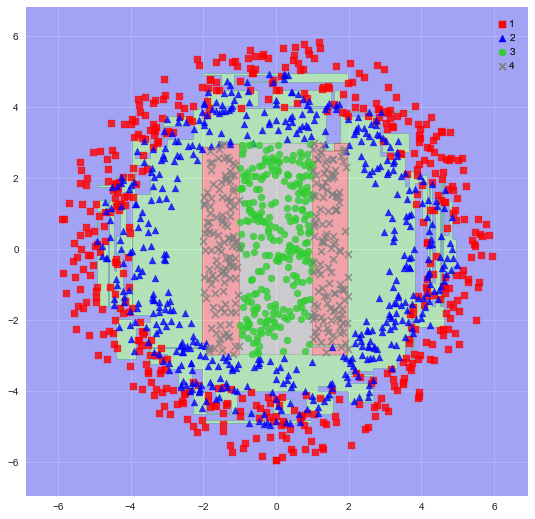

In [13]:
clf3 = DecisionTreeClassifier()
scores = cross_val_score(clf3, data[['x', 'y']], data.color, cv=5)
print(scores)
print(np.mean(scores))

clf3.fit(data[['x', 'y']], data.color.values.astype(np.integer));
plt.figure(figsize=(9,9));
plot_decision_regions(data[['x', 'y']].values, data.color.values.astype(np.integer), clf3);

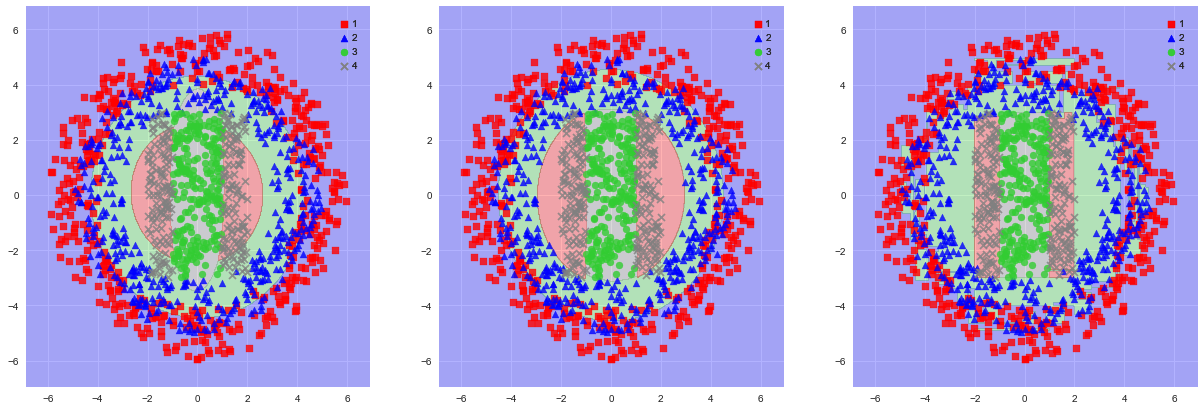

In [14]:
clfs = [make_pipeline(PolynomialFeatures(degree=2), LogisticRegression()), 
        SVC(kernel='poly', degree=2), 
        DecisionTreeClassifier()]

plt.figure(figsize=(21, 7));
gs = gridspec.GridSpec(1, len(clfs))

for i, clf in enumerate(clfs):
    ax = plt.subplot(gs[0, i])
    clf.fit(data[['x', 'y']], data.color);
    plot_decision_regions(data[['x', 'y']].values, data.color.values.astype(np.integer), clf, ax=ax);

# Ансамблирование

Первый случай:
```bash
1111111100 = 80% точности
1111111100 = 80% точности
1011111100 = 70% точности

Усреднение:
1111111100 = 80% точности
```

Второй случай:

```bash
1111111100 = 80% точности
0111011101 = 70% точности
1000101111 = 60% точности

Усреднение:
1111111101 = 90% точности
```

__Вывод:__ Хорошо усреднять классификаторы разной природы.

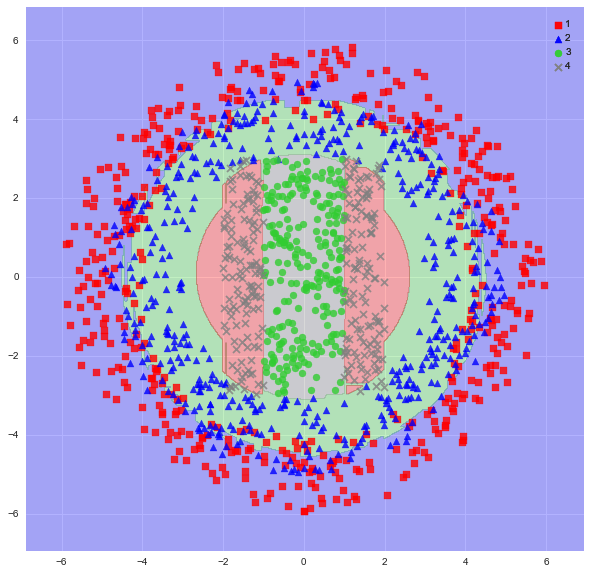

In [15]:
eclf = EnsembleVoteClassifier(clfs=clfs, voting='hard')
eclf.fit(data[['x', 'y']], data.color);

plt.figure(figsize=(10, 10));
plot_decision_regions(data[['x', 'y']].values, data.color.values.astype(np.integer), eclf);

In [16]:
scores = cross_val_score(eclf, data[['x', 'y']], data.color, cv=5)
print(scores)
print(np.mean(scores))

[ 0.82        0.84666667  0.86333333  0.85666667  0.79333333]
0.836


# Блэндинг

Классическая схема блэндинга:
![](images/blending1.png)

&nbsp;

Проблема, конечно, в разделении обучающей выборки на выборку для обучения классификаторов и выборку для обучения мета-алгоритма. В таком случае, например, разбивают выборку по-разному:

![](images/blending2.png)

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools

import sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from brew.base import Ensemble, EnsembleClassifier
from brew.stacking.stacker import EnsembleStack, EnsembleStackClassifier
from brew.combination.combiner import Combiner

from mlxtend.data import iris_data
from mlxtend.evaluate import plot_decision_regions

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
# Initializing Classifiers
clf1 = LogisticRegression(random_state=0)
clf2 = RandomForestClassifier(random_state=0)
clf3 = SVC(random_state=0, probability=True)

# Creating Ensemble
ensemble = Ensemble([clf1, clf2, clf3])
eclf = EnsembleClassifier(ensemble=ensemble, combiner=Combiner('mean'))

# Creating Stacking
layer_1 = Ensemble([clf1, clf2, clf3])
layer_2 = Ensemble([sklearn.clone(clf1)])

stack = EnsembleStack(cv=3)

stack.add_layer(layer_1)
stack.add_layer(layer_2)

sclf = EnsembleStackClassifier(stack)

clf_list = [clf1, clf2, clf3, eclf, sclf]
lbl_list = ['Logistic Regression', 'Random Forest', 'RBF kernel SVM', 'Ensemble', 'Stacking']

# Loading some example data
X, y = iris_data()
X = X[:,[0, 2]]

# WARNING, WARNING, WARNING
# brew requires classes from 0 to N, no skipping allowed
d = {yi : i for i, yi in enumerate(set(y))}
y = np.array([d[yi] for yi in y])

# Plotting Decision Regions
gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(10, 8))

itt = itertools.product([0, 1, 2], repeat=2)

for clf, lab, grd in zip(clf_list, lbl_list, itt):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(lab)
plt.show()

# Стекинг

![stacking](images/stacking.jpg)

Пример реализации: 
* https://github.com/Dyakonov/ml_hacks/blob/master/dj_stacking.ipynb - Дьяконов
* https://www.kaggle.com/mmueller/stacking-starter - FaR0n

In [20]:
from mlxtend.classifier import StackingCVClassifier, StackingClassifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
sclf = StackingCVClassifier(clfs, RandomForestClassifier())

In [23]:
scores = cross_val_score(sclf, data[['x', 'y']].values, data.color.ravel(), cv=5)
print(scores)
print(np.mean(scores))

[ 0.81666667  0.85333333  0.87333333  0.84666667  0.8       ]
0.838


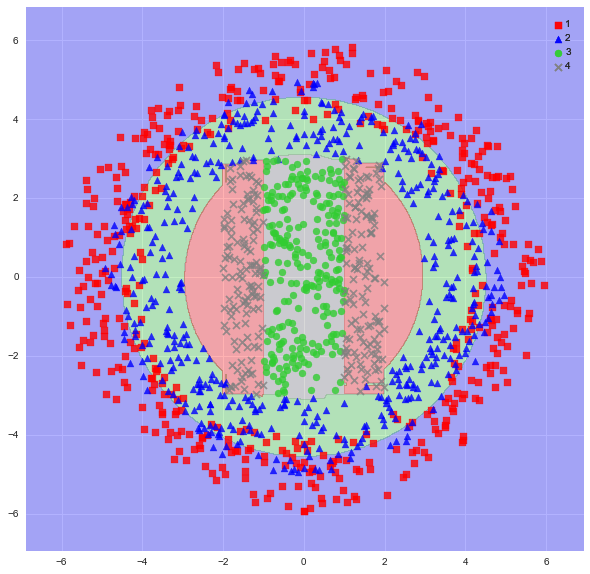

In [24]:
sclf.fit(data[['x', 'y']].values, data.color);
plt.figure(figsize=(10, 10));
plot_decision_regions(data[['x', 'y']].values, data.color.values.astype(np.integer), sclf);

https://alexanderdyakonov.wordpress.com/